## Imports

In [64]:
%run base.ipynb
%load_ext autoreload
%autoreload 2

import pickle
from tqdm.notebook import tqdm

import gym
import matplotlib.pyplot as plt
import numpy as np
import tabulate

from abides_gym_custom_execution_environment import SubGymMarketsCustomExecutionEnv
from sigqlearning_qfunctions import SigQFunction
from sigqlearning_test_execution import test
from sigqlearning_train_execution import train
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Register the environment as gym environment

In [ ]:
# register execution env for gym use 
from gym.envs.registration import register

register(
    id="custom-execution-v0",
    entry_point=SubGymMarketsCustomExecutionEnv,
)

In [66]:
# environment parameters
env_params = dict(
    background_config="rmsc04",
    mkt_close="10:06:00",
    timestep_duration="10s",
    first_interval="00:05:00",
    observation_interval="00:01:00",            
    order_fixed_size=100,
    max_inventory=2000,
    starting_inventory=1400,
    terminal_inventory_reward=-1., # reward or penalty
    terminal_inventory_mode='quadratic', # linear, flat
    running_inventory_reward_dampener=0., # 0.6, 1.0
    damp_mode="symmetric", # asymmetric
    debug_mode=False
)

# helper function to generate environment with specified parameters
def generate_env(seed=None):
    """
    generates specific environment with the parameters defined and set the seed
    """
    env = gym.make(id = "custom-execution-v0", **env_params)
    if seed is not None:
        env.seed(seed)
    return env


In [67]:
# generate the custom execution environment
env = generate_env()

## Training

### Learn a Q-function estimate
Learn a Q-function estimate with Signature-Q-learning. We run 5 different seeds.

**Note**: This code cell takes a long time to run. Would recommend to copy this cell in a python script and let it run in the back with [screen](https://linuxize.com/post/how-to-use-linux-screen/) or [tmux](https://www.hamvocke.com/blog/a-quick-and-easy-guide-to-tmux/) for instance. 

In [5]:
# signature parameters
sigq_params = dict(
    sig_depth = 7,
    basepoint = True, 
    initial_bias = 0.1
)

# training parameter
training_params = dict(
    episodes = 2000,
    discount=1.0,
    learning_rate = 1e-4,
    learning_rate_decay = dict(mode='linear', end_value=1e-7, epochs=1900), 
        #dict(mode='exponential', factor=0.998, end_value=1e-07),
    exploration = 'greedy',
    epsilon = 0.8,
    epsilon_decay = dict(mode='linear', end_value=0.02, epochs=1000),
    decay_mode = 'episodes',
    debug_mode = None,
    progress_display = 'livelossplot'
)

In [ ]:
# number of training runs
n_runs = 5

# dict to store results
training_results_dict = {run : [] for run in range(n_runs)}
training_seeds = {
    run : seed for run,seed 
    in zip(training_results_dict, utils.generate_prime_seeds(n_runs))
}
final_Q_functions = {}

# training runs
runs_pbar = tqdm(training_results_dict.keys())
for run in runs_pbar:
    runs_pbar.set_description(f"Training run")
    
    env = generate_env(training_seeds[run])
    sigqfunction = SigQFunction(env, **sigq_params)
    training_results_dict[run] = train(env, sigqfunction, **training_params)
    final_Q_functions[run] = sigqfunction.state_dict()
    del sigqfunction, env # for safety in case env.reset() does not work properly

#final_Q_functions = {run: run_results['indermediate'][-1] 
#                     for run, run_results in training_results_dict.items()}

In [7]:
training_results_dict_all = training_results_dict

### Save training results

**Note**: Training results are saved under `../results/file_name + today + id`, where `today` is the current date
in the form `%Y%M%d` and `id` an upper case letter to identifiy multiple files saved on the same date.

In [78]:
file_name = "custom_execution_training"
results_dict=dict(training_results=training_results_dict, final_Q_functions=final_Q_functions,
                  sig_params=sigq_params, training_params=training_params, env_params=env_params)
date_time_id = utils.save_results(results_dict, file_name)

In [ ]:
# custom_execution_v0_full_dampening
# 5 runs, i_0 = 400, oder_size=100, execution action space, with convergence to optimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 3,2,5,7,1, quadratic penalty C=-1, basepoint=T, discount=1., damp=1.

# custom_execution_v0_training_no_dampening
# 2 runs, i_0 = 400, oder_size=100, execution action space, with convergence to suboptimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 1000 epis , epis 1000, seeds (1,2) , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# both runs not fully optimal, first only reduced down to 200, second overshoots then buys again and ends around -100

# custom_execution_v0_training_no_dampening_2
# 1 run, i_0 = 400, oder_size=100, execution action space, with convergence to optimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 1 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.

# custom_execution_v0_training_no_dampening_3
# 1 run, i_0 = 400, oder_size=100, execution action space, with convergence to SUBoptimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 1 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.

# custom_execution_v0_training_no_dampening_4
# 5 runs, i_0 = 400, oder_size=100, execution action space, some runs with convergence to suboptimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 1,2,3,5,7 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# unstable training, mainly learns to leave inventory untouched

# custom_execution_v0_training_no_dampening_5
# 5 runs, i_0 = 400, oder_size=100, execution action space, some runs with only one convergence to optimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 1,2,3,5,7 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# only run 2 learned an acceptable policy, number of episodes to little, reduction from high exploration to low to fast

# INVALID – RUN AGAIN
# custom_execution_v0_training_no_dampening_6
# 2 runs, i_0 = 400, oder_size=100, execution action space, some runs with convergence to suboptimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 2000 epis , epis 2000, seeds 5,7 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# both runs a bit suboptimal, first reduces too much end in [-200, 0], second also a little too much but good

# INVALID - RUN AGAIN 
# custom_execution_v0_training_no_dampening_7
# 2 runs, i_0 = 400, oder_size=100, execution action space, some runs with ?? convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 2000 epis , epis 2000, seeds 5,7 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# run 0 it learned a suboptimal policy, run a nearly optimal

# custom_execution_v0_training_no_dampening_8
# 2 runs, i_0 = 400, oder_size=100, execution action space, one run with convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr exp decay from 1e-3 with 0.995 , epis 2000, seeds 7,5 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0. 
# first runs optimal, second run shit

# custom_execution_v0_training_no_dampening_9
# 5 runs, i_0 = 400, oder_size=100, execution action space, no run with convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr exp decay from 1e-3 with 0.995 , epis 2000, seeds 1,2,3,5,7 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0. 
# shitty shit shit, why?

# custom_execution_v0_training_no_dampening_10
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.5, eps_end 0.02, lr exp decay from 1e-4 with 0.997 , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0. 
# first run did not learn anything, second suboptimal reduces only to 200 high variance, lr decay too fast

# custom_execution_v0_training_no_dampening_11
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.5, eps_end 0.02, lr episode exp decay from 1e-4 with 0.998 , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0. 
# first run did not learn much reduces only 300, second suboptimal reduces reduces a bit too much to -100

# ------ -------
# custom_execution_v0_training_no_dampening_12
# eps_start = 0.8 eps_end = 0.02, discount = 1.0
# 2 runs, i_0 = 400, oder_size=100, execution action space, convergence to almost optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# both runs convergence to almost optimal policy, 2nd a bit better, both overshoot a little at beginning then buy again
# for intermediate -3, testing was even slightly better
# first Q values converge to mean reward with reward window [-200:0]

# custom_execution_v0_training_no_dampening_13
# eps_start = 0.8 eps_end = 0.02, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, convergence optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# even a better than _12, it does not overshoot reduction of inventory, range of terminal inventory is smaller
# first run sometimes sells at end of episode, second run very stable 
# for intermediate -3 testing run_1 was better, run_2 sells to much at episode end, before would be really good
# first Q converges to value a bit below mean reward for both runs

# custom_execution_v0_training_no_dampening_14
# eps_start = 0.8 eps_end = 0.01, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, convergence optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.01, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# second run is really good, first run only reduces down to ~200 unfortunately 

# custom_execution_v0_training_no_dampening_15
# eps_start = 0.8 eps_end = 0.01, discount = 1.0
# 2 runs, i_0 = 400, oder_size=100, execution action space, convergence optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.01, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1.0, damp=0.
# First run learned nothing, reduces way too much than overshoots buying. Second run ok but in range [0, -200]

# ------ with eps start 0.5 ------
# custom_execution_v0_training_no_dampening_16
# eps_start = 0.5, eps_end = 0.02, discount = 1.0
# 2 runs, i_0 = 400, oder_size=100, execution action space, with no convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.5, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# no run did learn a good Q estimate
# first Q values did not converge properly

# custom_execution_v0_training_no_dampening_17
# eps_start = 0.5, eps_end = 0.02, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, no convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.5, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# first run failed to converge, highly unstable in training, second run learned suboptimal policy, that reduces to 300 and only at end to 200
# first Q values did not converge

# ------ with decay mode 'steps' ------
# custom_execution_v0_training_no_dampening_18
# eps_start = 0.5, eps_end = 0.02, discount = 1.0, linear step decay
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 0.5, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# 1st run suboptimal, reduced inventory but to a range [-100,100] and overshoot in buying and selling at beginning
# 2nd run did not learn anything useful

# custom_execution_v0_training_no_dampening_19
# eps_start = 0.8, eps_end = 0.02, discount = 1.0, linear step decay
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# 1st run did not learn good policy, reduced halfway through the episode not stable
# 2nd run better, overshoots a little, intermediate at -31 is perfect

# custom_execution_v0_training_no_dampening_20
# eps_start = 1.0, eps_end = 0.02, discount = 1.0, linear step decay
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# 1st run suboptimal, wide range of terminal inventory on [-100,100]
# 2nd run learned good policy, but not particularly better than other cases with episode decay
# BUT perfect convergence of 1st Q value to mean reward !

# custom_execution_v0_training_no_dampening_20a
# eps_start = 1.0, eps_end = 0.02, discount = 1.0, linear step decay, order size = 50
# 2 runs, i_0 = 400, oder_size=50, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# ADD DESCRIPTION

# TO RUN

# custom_execution_v0_training_no_dampening_21
# eps_start = 1.0, eps_end = 0.02, discount = 1.0, linear step decay, lr start 5*1e-5
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr 5*1e-5 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.

# custom_execution_v0_training_no_dampening_22
# eps_start = 1.0, eps_end = 0.02, discount = 1.0, exp step decay
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr exp step decay from 1e-4 with 0.999985 , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.

# custom_execution_v0_training_no_dampening_23
# eps_start = 0.5, eps_end = 0.02, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 0.5, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# NO NEED FOR THIS ONE

# custom_execution_v0_training_no_dampening_24
# eps_start = 0.8, eps_end = 0.02, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.

# -------------
# custom_execution_v0_training_no_dampening_100
# eps_start = 0.8, eps_end = 0.02, discount = 1.0, linear step decay, order size = 50, current_inv as reward
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# ADD DESCRIPTION

# custom_execution_v0_training_no_dampening_101
# eps_start = 0.8 eps_end = 0.02, discount = 1.0, linear episode decay, current_inv as reward
# 1 run, i_0 = 400, oder_size=100, execution action space, with ?? convergence to almost optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1, quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# ADD DESCRIPTION

# custom_execution_v0_training_no_dampening_102
# eps_start = 0.8 eps_end = 0.02, discount = 1.0, linear episode decay, previous_inv as reward with linear terminal reward
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1, quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# 1st run learned nothing, 2nd run close to optimal, narrow range, similar to runs with same setup but quadratic terminal reward
# 3rd run with seed = 3 is running # ADD DECRIPTION

# custom_execution_v0_training_no_dampening_103
# eps_start = 0.8 eps_end = 0.02, discount = 1.0, linear episode decay, current as reward with flat terminal reward and 0 exploration
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.0, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1, quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# both runs learned a solid policy, however both only reduced to the range [50, 100] and not furhter
# -> not saved

# ************************************************************************************************************************************************************************************************************************************************************************************************************
# custom_execution_v0_training_no_dampening_104
# eps_start = 0.8, eps_mid=0.02, eps_end = 0.0, discount = 1.0, linear episode decay, previous as reward with flat terminal reward
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl mixed linear 2000 epis, eps_start 0.8, eps_mid=0.02 eps_end 0.0, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 2,3, flat terminal penalty C=-1, basepoint=T, discount=1., damp=0.


# TO TRY:
# start with i_0=1400, i_max=2000



## Training results plots

### Plot single training run results

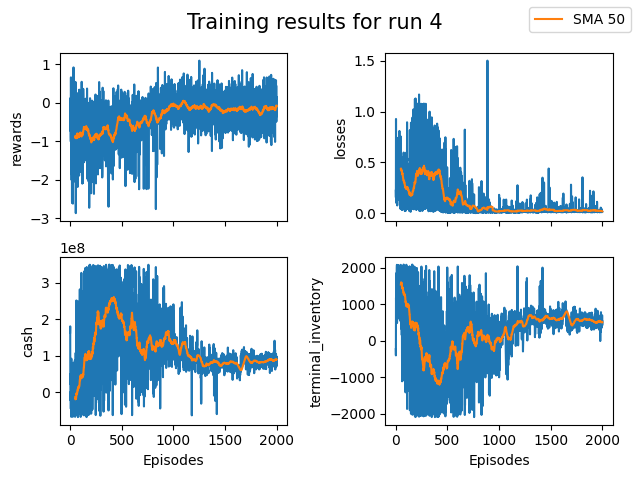

In [80]:
# select training run number for plotting
run_id = 4
utils.plot_run_results(training_results_dict, run_id, figsize=None)

### Plot results averaged over runs

And save each plot as single file in `..\figures`. Each file name contains `date_time_id` of the corresponding file containing saved training results.

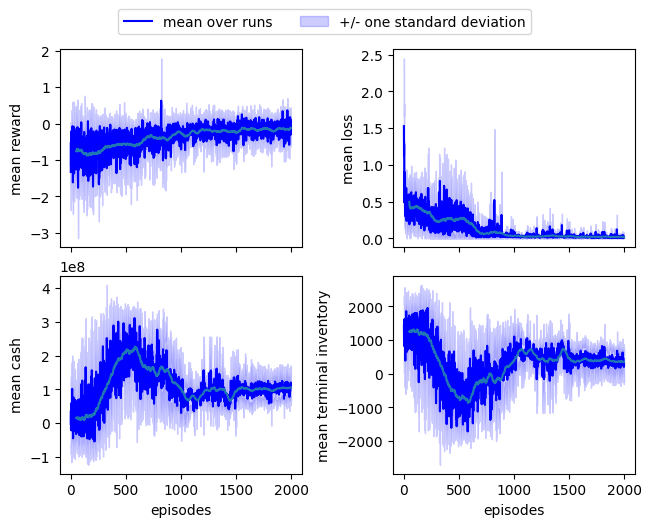

In [81]:
utils.plot_mean_results(training_results_dict, figsize=None)
utils.save_mean_results_plots(training_results_dict, date_time_id=date_time_id, 
                              file_name='custom_execution', show=False)

### Plot single episode observation / action history.

To gain a more qualitative insight into the policies based on the learned Q-functions, we plot the observastion and action trajectories of a single training episode.

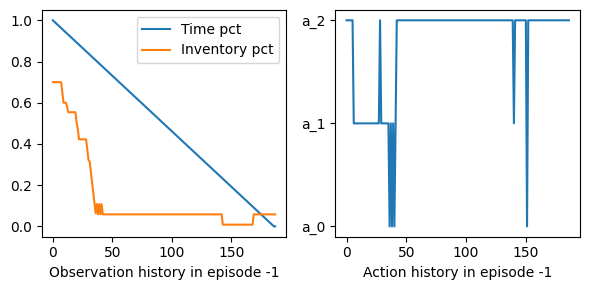

In [72]:
run_id = 3
episode_id = -1

observation_history = list(training_results_dict[run_id]["observations"][episode_id])
action_history = training_results_dict[run_id]["actions"][episode_id]

utils.plot_observation_action_history(observation_history, action_history, 
                                      episode_id, n_actions=env.action_space.n)

## Testing

To load prior saved training results, set `load_training_results_flag` to True and paste trainings results' file name.

In [79]:
load_training_results_flag = True

if load_training_results_flag:
    date_time_id = '20240913_A'
    file_path = '../results/custom_execution_training_{}.pkl'.format(date_time_id)
    # load training results
    with open(file_path, 'rb') as fin:        
        loaded_training_dict = pickle.load(fin)

    training_results_dict = loaded_training_dict["training_results_dict"]
    final_Q_functions = loaded_training_dict["final_Q_functions"]
    sigq_params = loaded_training_dict["sig_params"]
    training_params = loaded_training_dict["training_params"]
    env_params = loaded_training_dict["env_params"]
    print("*** training results {} loaded ***".format(date_time_id))

*** training results 20240913_A loaded ***


### Test a learned Q-function estimate

We test the Q-functions learning in training. If an intermediate Q-function estimate saved at some checkpoint instead of the last one for each training run should be tested, set `checkpoint_policy_flag` to True and select a checkpoint.

In [82]:
checkpoint_flag = True
checkpoint = -1

n_test_episodes = 5
test_results_dict = {run : [] for run in range(n_runs)}
seeds = utils.generate_prime_seeds(100, shuffle=True)

runs_pbar = tqdm(test_results_dict.keys())
for run in runs_pbar:
    runs_pbar.set_description(f"Test run")

    env = generate_env(seeds[run])
    sigqfunction = SigQFunction(env, **sigq_params)
    state_dict = final_Q_functions[run] if not checkpoint_flag \
        else training_results_dict[run]["intermediate"][checkpoint]
    sigqfunction.load_state_dict(state_dict)
    
    test_results_dict[run] = test(env, sigqfunction, n_test_episodes, debug_mode="info")
    del sigqfunction, env # for safety in case env.reset() does not work properly

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Episode 0 | Reward -0.63555 | Inventory 988 | Steps in run 181
Episode 1 | Reward -0.14597 | Inventory 1013 | Steps in run 362
Episode 2 | Reward -0.17788 | Inventory 963 | Steps in run 543
Episode 3 | Reward 0.26735 | Inventory 981 | Steps in run 724
Episode 4 | Reward -0.03895 | Inventory 842 | Steps in run 905


  0%|          | 0/5 [00:00<?, ?it/s]

Episode 0 | Reward -0.10869 | Inventory 504 | Steps in run 181
Episode 1 | Reward -0.55947 | Inventory -347 | Steps in run 362
Episode 2 | Reward -0.28211 | Inventory -478 | Steps in run 543
Episode 3 | Reward -0.27707 | Inventory -112 | Steps in run 724
Episode 4 | Reward 0.14357 | Inventory 735 | Steps in run 905


  0%|          | 0/5 [00:00<?, ?it/s]

Episode 0 | Reward -0.17272 | Inventory 265 | Steps in run 181
Episode 1 | Reward -0.00395 | Inventory 0 | Steps in run 362
Episode 2 | Reward 0.18149 | Inventory -66 | Steps in run 543
Episode 3 | Reward -0.17805 | Inventory -66 | Steps in run 724
Episode 4 | Reward 0.05804 | Inventory -97 | Steps in run 905


  0%|          | 0/5 [00:00<?, ?it/s]

Episode 0 | Reward -0.04316 | Inventory 94 | Steps in run 181
Episode 1 | Reward -0.30556 | Inventory 110 | Steps in run 362
Episode 2 | Reward -0.05528 | Inventory 254 | Steps in run 543
Episode 3 | Reward -0.22126 | Inventory 362 | Steps in run 724
Episode 4 | Reward -0.39277 | Inventory 379 | Steps in run 905


  0%|          | 0/5 [00:00<?, ?it/s]

Episode 0 | Reward -0.29532 | Inventory 608 | Steps in run 181
Episode 1 | Reward -0.30389 | Inventory 498 | Steps in run 362
Episode 2 | Reward -0.32298 | Inventory 522 | Steps in run 543
Episode 3 | Reward -0.83461 | Inventory 615 | Steps in run 724
Episode 4 | Reward 0.10562 | Inventory 617 | Steps in run 905


### Save test results

In [ ]:
execute_cell_flag = False

if execute_cell_flag:
    file_path = '../results/custom_execution_test_results_{}.pkl'.format(date_time_id)
    with open(file_path, 'wb') as fout:  
        pickle.dump(test_results_dict, fout)

## Test results statistics

The following statisitcs are reported for each test run:
- Mean reward and standard deviation
- Mean terminal inventory and standard deviation
- Minimum / maximum inventory in test run
- Mean terminal cash and standard deviation
- Mean first observation value

In [94]:
test_stats = []
cols = [
    'Mean\nreward', 'Std\nreward', 'Mean terminal\ninventory', 'Std terminal\ninventory',
    'Min terminal\ninventory', 'Max terminal\ninventory', 'Mean\nterminal cash', 'Std\nterminal cash', 
    'Initial\nvalue'
]
rows = ['Run {}'.format(i) for i in range(n_runs)]

for test_run in test_results_dict.values():
    run_stats = []
    run_stats.append(np.mean(test_run['rewards'])) # mean reward
    run_stats.append(np.std(test_run['rewards'])) # std reward
    run_stats.append(np.mean(test_run['terminal_inventories'])) # mean terminal inventory
    run_stats.append(np.std(test_run['terminal_inventories'])) # std terminal inventory
    run_stats.append(int(np.min(test_run['terminal_inventories']))) # min terminal inventory
    run_stats.append(int(np.max(test_run['terminal_inventories']))) # max terminal inventory
    run_stats.append(np.mean(test_run['cash'])/100) # mean terminal cash
    run_stats.append(np.std(test_run['cash'])/10) # std terminal cash
    run_stats.append(test_run['initial_values'][-1])

    test_stats.append(run_stats)
 
print(tabulate.tabulate(test_stats, headers=cols, showindex=rows, floatfmt='.4f'))

           Mean       Std    Mean terminal    Std terminal    Min terminal    Max terminal             Mean              Std    Initial
         reward    reward        inventory       inventory       inventory       inventory    terminal cash    terminal cash      value
-----  --------  --------  ---------------  --------------  --------------  --------------  ---------------  ---------------  ---------
Run 0   -0.1462    0.2909         957.4000         59.8886             842            1013      443709.3300      598524.6932    -0.2521
Run 1   -0.2168    0.2310          60.4000        476.9564            -478             735     1340560.4060     4768319.4113    -0.2229
Run 2   -0.0230    0.1380           7.2000        132.7304             -97             265     1393945.9160     1329804.5250    -0.1144
Run 3   -0.2036    0.1373         239.8000        120.5129              94             379     1160960.7380     1204759.9864    -0.1334
Run 4   -0.3302    0.2988         572.0000      

## Confidence intervals


Mean std error of mean reward: 0.1096


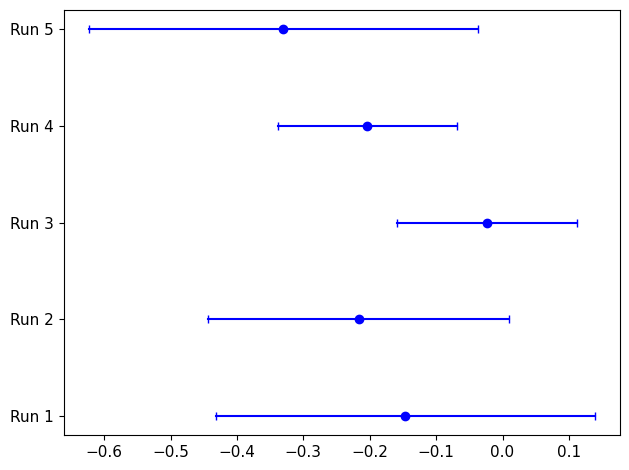

In [112]:
conf_int_rewards, mean_std_error_reward = utils.compute_confidence_intervals(
    test_results_dict, 'rewards'
)
print(f'\nMean std error of mean reward: {mean_std_error_reward:.4f}')
utils.plot_confidence_intervals(conf_int_rewards, 'rewards', figsize=None)

## Test results plots

### Plot single test run and episode

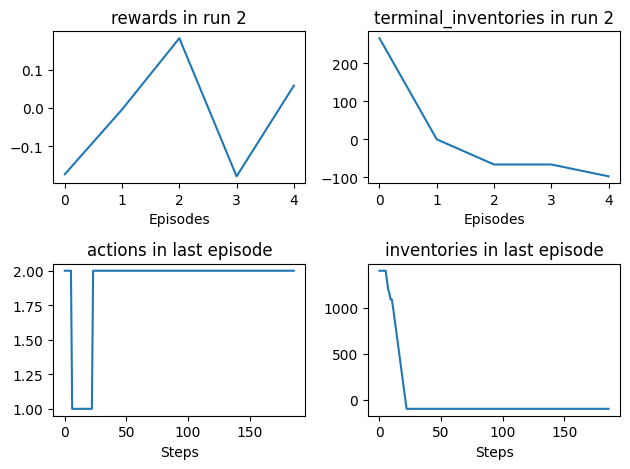

In [101]:
run_id = 2
episode_id = -1
test_run = test_results_dict[run_id]

rolling_avg_flag = False
rolling_avg_window = 0


names = ["rewards", "terminal_inventories", "actions", "inventories"]
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False)
for ax, id in zip(axes.flat, range(4)):
    ax.set_title(names[id] + f' in run {run_id}' if id < 2 else names[id] + (
                     " in episode " + str(episode_id) if episode_id != -1 else " in last episode")
    )
    if episode_id is not None:
        ax.plot(test_run[names[id]] if id < 2 else test_run[names[id]][episode_id])
    else:
        ax.plot(test_run[names[id]]) if id < 2 else [ax.plot(x) for x in test_run[names[id]]]

    if rolling_avg_flag:
        ax.plot(utils.moving_average(
                test_run[names[id]] if id < 2 else test_run[names[id]][episode_id], rolling_avg_window
            ))
    ax.set_xlabel("Episodes" if id < 2 else "Steps")
fig.tight_layout()
plt.show()

## Check first Q-value convergence

**Note**: We need to compare this with the average episode reward once all runs are performed. Also longer runs might be needed since I expect the average episode reward to be above the Q values reached with 250 episodes 

### With intermediate Q functions

In [ ]:
import torch
import math

run_id = 0
mean_epis = 100

observation_interval_flag = True if env.observation_interval > 0 else False
print("observe first interval: {}".format(observation_interval_flag))

basepoint_flag = True
print("basepoint: {}".format(basepoint_flag))

first_Q_values = []
policy = SigQFunction(env, truncation_order)

if observation_interval_flag:
    # steps to only observe
    do_nothing_steps = max(1, math.floor(env.observation_interval / env.timestep_duration))
    first_history = list(training_results_dict[run_id]["observations"][0])[0:do_nothing_steps+1]
else:
    # no observation before first action
    first_history = list(training_results_dict[run_id]["observations"][0])[0:2]
first_history = torch.tensor(
    first_history, requires_grad=False, dtype=torch.float
).unsqueeze(0)

for state_dict in training_results_dict[run_id]["intermediate"]: 
    policy.load_state_dict(state_dict)    
    policy.eval()
    sig = policy.compute_signature(first_history, basepoint=basepoint_flag)  
    first_Q_values.append(policy(sig)[0].detach())
    policy.train()     

first_Q_values = torch.stack(first_Q_values, dim=0)
plt.plot(first_Q_values)
mean_reward = torch.tensor(training_results_dict[run_id]["rewards"][-mean_epis:]).mean()
plt.plot([mean_reward for x in range(len(first_Q_values))])
plt.legend(["Action " + str(i) for i in range(first_Q_values.shape[-1])],
           loc="best")
plt.show()

first_Q_mean = first_Q_values.mean(dim=-1)
plt.plot(first_Q_mean)
mean_reward = torch.tensor(training_results_dict[run_id]["rewards"][-mean_epis:]).mean()
plt.plot([mean_reward for x in range(len(first_Q_mean))])
plt.show()


### With saved Q-values

This section currently only works for training run `results_v2_copy_1214_2` and `results_v2_copy_1215_1`.

In [17]:
Q_values = list(map(torch.detach, results["first_Q_values"]))
Q_values = [
    torch.stack(Q_values[i:i+181])
    for i in range(0, len(Q_values)-1, 181)
]

In [ ]:
episode_id = -1
plt.plot(Q_values[episode_id])
plt.legend(["Action " + str(i) for i in range(Q_values[episode_id].shape[-1])],
           loc="upper left")
plt.title("Q values in episode {}".format(episode_id))
plt.show()

first_Q_values = torch.stack([x[0] for x in Q_values], dim=0)
mean_reward = torch.tensor(results["rewards"][-300:]).mean()

plt.plot(first_Q_values)
plt.plot([mean_reward for x in range(len(first_Q_values))])
plt.legend([
        "Action " + str(i) 
        if i < first_Q_values.shape[-1] else "Mean reward" 
        for i in range(first_Q_values.shape[-1]+1)
    ],
    loc="upper right")
plt.title("First Q values per episode")
plt.show()
